In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, confusion_matrix, roc_curve, auc, RocCurveDisplay

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pycm import ConfusionMatrix

In [2]:
# all data found on github repo
df_reviews = pd.read_csv('https://tinyurl.com/moviereviewsdata')

df_train, df_test = train_test_split(
    df_reviews, 
    test_size = 0.25, 
    random_state = 123
)

## Regression Metrics

In [3]:
# we'll use 'features' later also
features = [
    "review_year_0", 
    "release_year_0",
    "age_sc", 
    "length_minutes_sc", 
    "total_reviews_sc", 
    "word_count_sc", 
    "genre", 
    ]

model =  'rating ~ ' + " + ".join(features)

model_lr_train = smf.ols(formula = model, data = df_train).fit()

In [4]:
model =  'rating_good ~ ' + " + ".join(features)

model_class_train = smf.glm(
    formula = model,
    data = df_train,
    family = sm.families.Binomial()
).fit()

## Understanding The Features

### Average marginal effects

In [5]:
fudge_factor = 1e-3

fudge_plus = model_class_train.predict(
    df_train.assign(
        word_count_sc = df_train.word_count_sc + fudge_factor/2
    )
)

fudge_minus = model_class_train.predict(
    df_train.assign(
        word_count_sc = df_train.word_count_sc - fudge_factor/2
    )
)

marginal_effect = np.mean(fudge_plus - fudge_minus) / fudge_factor

marginal_effect

-0.09447284318194568

### Marginal means

In [6]:
marginal_means = pd.DataFrame({
    "genre": df_train.genre.unique(),
    "avg_pred": [
        model_lr_train.predict(
            df_train.assign(genre = g)
        ).mean()
        for g in df_train.genre.unique()
    ]
})

marginal_means

,genre,avg_pred
0,Romance,2.864043
1,Other,2.847952
2,Sci-Fi,2.823101
3,Drama,3.405924
4,Horror,2.847344
5,Action/Adventure,2.840424
6,Kids,2.803119
7,Comedy,3.360565


### Counterfactual Predictions

In [7]:
df_happiness_2018 = pd.read_csv('https://tinyurl.com/527pbc4v')

model_happiness = smf.ols(
    formula = 'happiness_score ~ \
        log_gdp_per_capita \
        + healthy_life_expectancy_at_birth \
        + generosity \
        + freedom_to_make_life_choices \
        + confidence_in_national_government',
    data = df_happiness_2018
).fit()

df_us_russia = df_happiness_2018[
        df_happiness_2018.country.isin(['United States', 'Russia'])
    ]

happiness_gdp_freedom_values = df_happiness_2018.loc[
    df_happiness_2018.country.isin(['United States', 'Russia']),
    ['log_gdp_per_capita', 'freedom_to_make_life_choices']
]

base_predictions = model_happiness.predict(df_us_russia)

# switch up their GDP and freedom!
df_switch = df_us_russia.copy()

df_switch[['log_gdp_per_capita', 'freedom_to_make_life_choices']] = (
    df_switch[['log_gdp_per_capita', 'freedom_to_make_life_choices']].values[::-1]
)    

switch_predictions = model_happiness.predict(df_switch)

pd.DataFrame({
    'country': ['Russia', 'USA'],
    'base_predictions': base_predictions,
    'switch_predictions': switch_predictions,
    'diff_in_happiness': switch_predictions - base_predictions
}).round(3)

,country,base_predictions,switch_predictions,diff_in_happiness
85,Russia,5.676,6.374,0.698
106,USA,6.798,6.100,-0.698


### SHAP Values

Redo previous model using raw scale data.

In [8]:
model_lr_3feat = smf.ols(
    formula = 'rating ~ \
    age \
    + release_year \
    + length_minutes',
    data = df_reviews
).fit()

In [9]:
# first we need to get the average prediction
avg_pred = model_lr_3feat.predict(df_reviews).mean()

# observation of interest we want shap values for
obs_of_interest = pd.DataFrame({
    'age': 30,
    'release_year': 2020,
    'length_minutes': 110
}, index = ['new_observation'])

# then we need to get the prediction for the feature value of interest
# for all observations, and average them
pred_age_30 = model_lr_3feat.predict(
    df_reviews.assign(
        age = obs_of_interest.loc['new_observation', 'age']
    )
)

pred_year_2022 = model_lr_3feat.predict(
    df_reviews.assign(
        release_year = obs_of_interest.loc['new_observation', 'release_year']
    )
)

pred_length_110 = model_lr_3feat.predict(
    df_reviews.assign(
        length_minutes = obs_of_interest.loc['new_observation', 'length_minutes']
    )
)

# then we can calculate the shap values
shap_value_ours = pd.DataFrame({
    'age': pred_age_30.mean() - avg_pred,
    'release_year': pred_year_2022.mean() - avg_pred,
    'length_minutes': pred_length_110.mean() - avg_pred
}, index = ['new_observation'])


In [10]:

# now use the shap package for this; it does not work with statsmodels though,
# and single feature models are a bit cumbersome, 
# but we still get there in the end!
import shap
from sklearn.linear_model import LinearRegression

# set data up for shap and sklearn
fnames = [
    'age', 
    'release_year', 
    'length_minutes'
]

X = df_reviews[fnames]
y = df_reviews['rating']

# use a linear model that works with shap
model_reviews = LinearRegression().fit(X, y)

# 1000 instances for use as the 'background distribution'
X_sample = shap.maskers.Independent(data = X, max_samples = 1000)  

# # compute the SHAP values for the linear model
explainer = shap.Explainer(
    model_reviews.predict, 
    X_sample   
)

shap_values = explainer(obs_of_interest)

shap_value_package = pd.DataFrame(
    shap_values.values[0, :], 
    index = fnames, 
    columns = ['new_observation']
).T

pd.concat([shap_value_ours, shap_value_package]).round(3)

,age,release_year,length_minutes
new_observation,0.063,0.206,-0.141
new_observation,0.063,0.206,-0.141


### Global assessment of feature importance

In [11]:
model_importance = smf.ols(
    formula = 'rating ~ \
        word_count \
        + age \
        + review_year \
        + release_year \
        + length_minutes \
        + children_in_home \
        + total_reviews',
    data = df_reviews
).fit()

<Axes: >

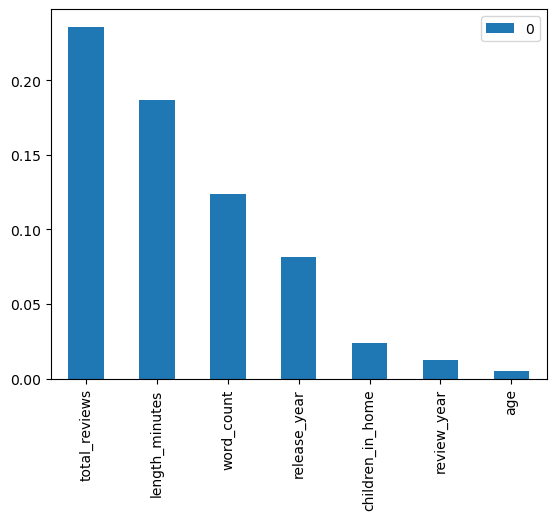

In [12]:

from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
import pandas as pd

y = df_reviews['rating']
X = df_reviews[['word_count', 'age', 'review_year', 'release_year', 'length_minutes', 'children_in_home', 'total_reviews']]
model = LinearRegression().fit(X, y)

importance = permutation_importance(model, X, y, n_repeats=30, random_state=0)

(
    pd.DataFrame(
        importance.importances_mean, 
        index=X.columns
    )
    .sort_values(by=0, ascending=False)
    .plot(kind='bar')
)